Generative models tend to learn data distributions in order to make some similar data.

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [242]:
# Read data
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [243]:
# Data properties
print(f"minimum name length: {min(len(w) for w in words)}")
print(f"maximum name length: {max(len(w) for w in words)}")
print(f"average name length: {sum([len(w) for w in words])/len(words)}")

minimum name length: 2
maximum name length: 15
average name length: 6.122217712983486


In [244]:
def create_bigrams(data: list):
    word_dict = {}
    for w in data:
        # chs = ['<S>'] + list(w) + ['<E>']
        chs = ['.'] + list(w) + ['.'] # doing '<S>' + w would tokenize < and > as well since zip would decompose them
        for ch1, ch2 in zip(chs, chs[1:]):
            bigram = (ch1, ch2)
            word_dict[bigram] = word_dict.get(bigram, 0) + 1
    
    return word_dict

bigrams = create_bigrams(words)

In [245]:
# probability distribution
probabilities = sorted(bigrams.items(), key= lambda i: i[1], reverse=True)
print(f"Top 5 most pair character occurences: {probabilities[:5]}")

Top 5 most pair character occurences: [(('n', '.'), 6763), (('a', '.'), 6640), (('a', 'n'), 5438), (('.', 'a'), 4410), (('e', '.'), 3983)]


In [246]:
def char_to_int(data):
    char_id = {}
    chars = sorted(set(''.join(data)))
    for i, c in enumerate(chars):
        char_id[c] = i+1
    
    # char_id['<S>'] = 26
    # char_id['<E>'] = 27
    char_id['.'] = 0 # since it is probability not having <S> and <E> is not of a big deal because we don't want them to be chosen
    # these should never be in our probabilities and candidates

    return char_id


def int_to_char(data):
    int_char = {v:k for k,v in data.items()}
    return int_char


def bigram_matrix(data, char_id):
    matrix = torch.zeros((27,27), dtype=torch.int32)
    for k, v in data.items():
        matrix[char_id[k[0]]][char_id[k[1]]] = v 

    return matrix

char_id = char_to_int(words)
id_char = int_to_char(char_id)
N = bigram_matrix(bigrams, char_id)

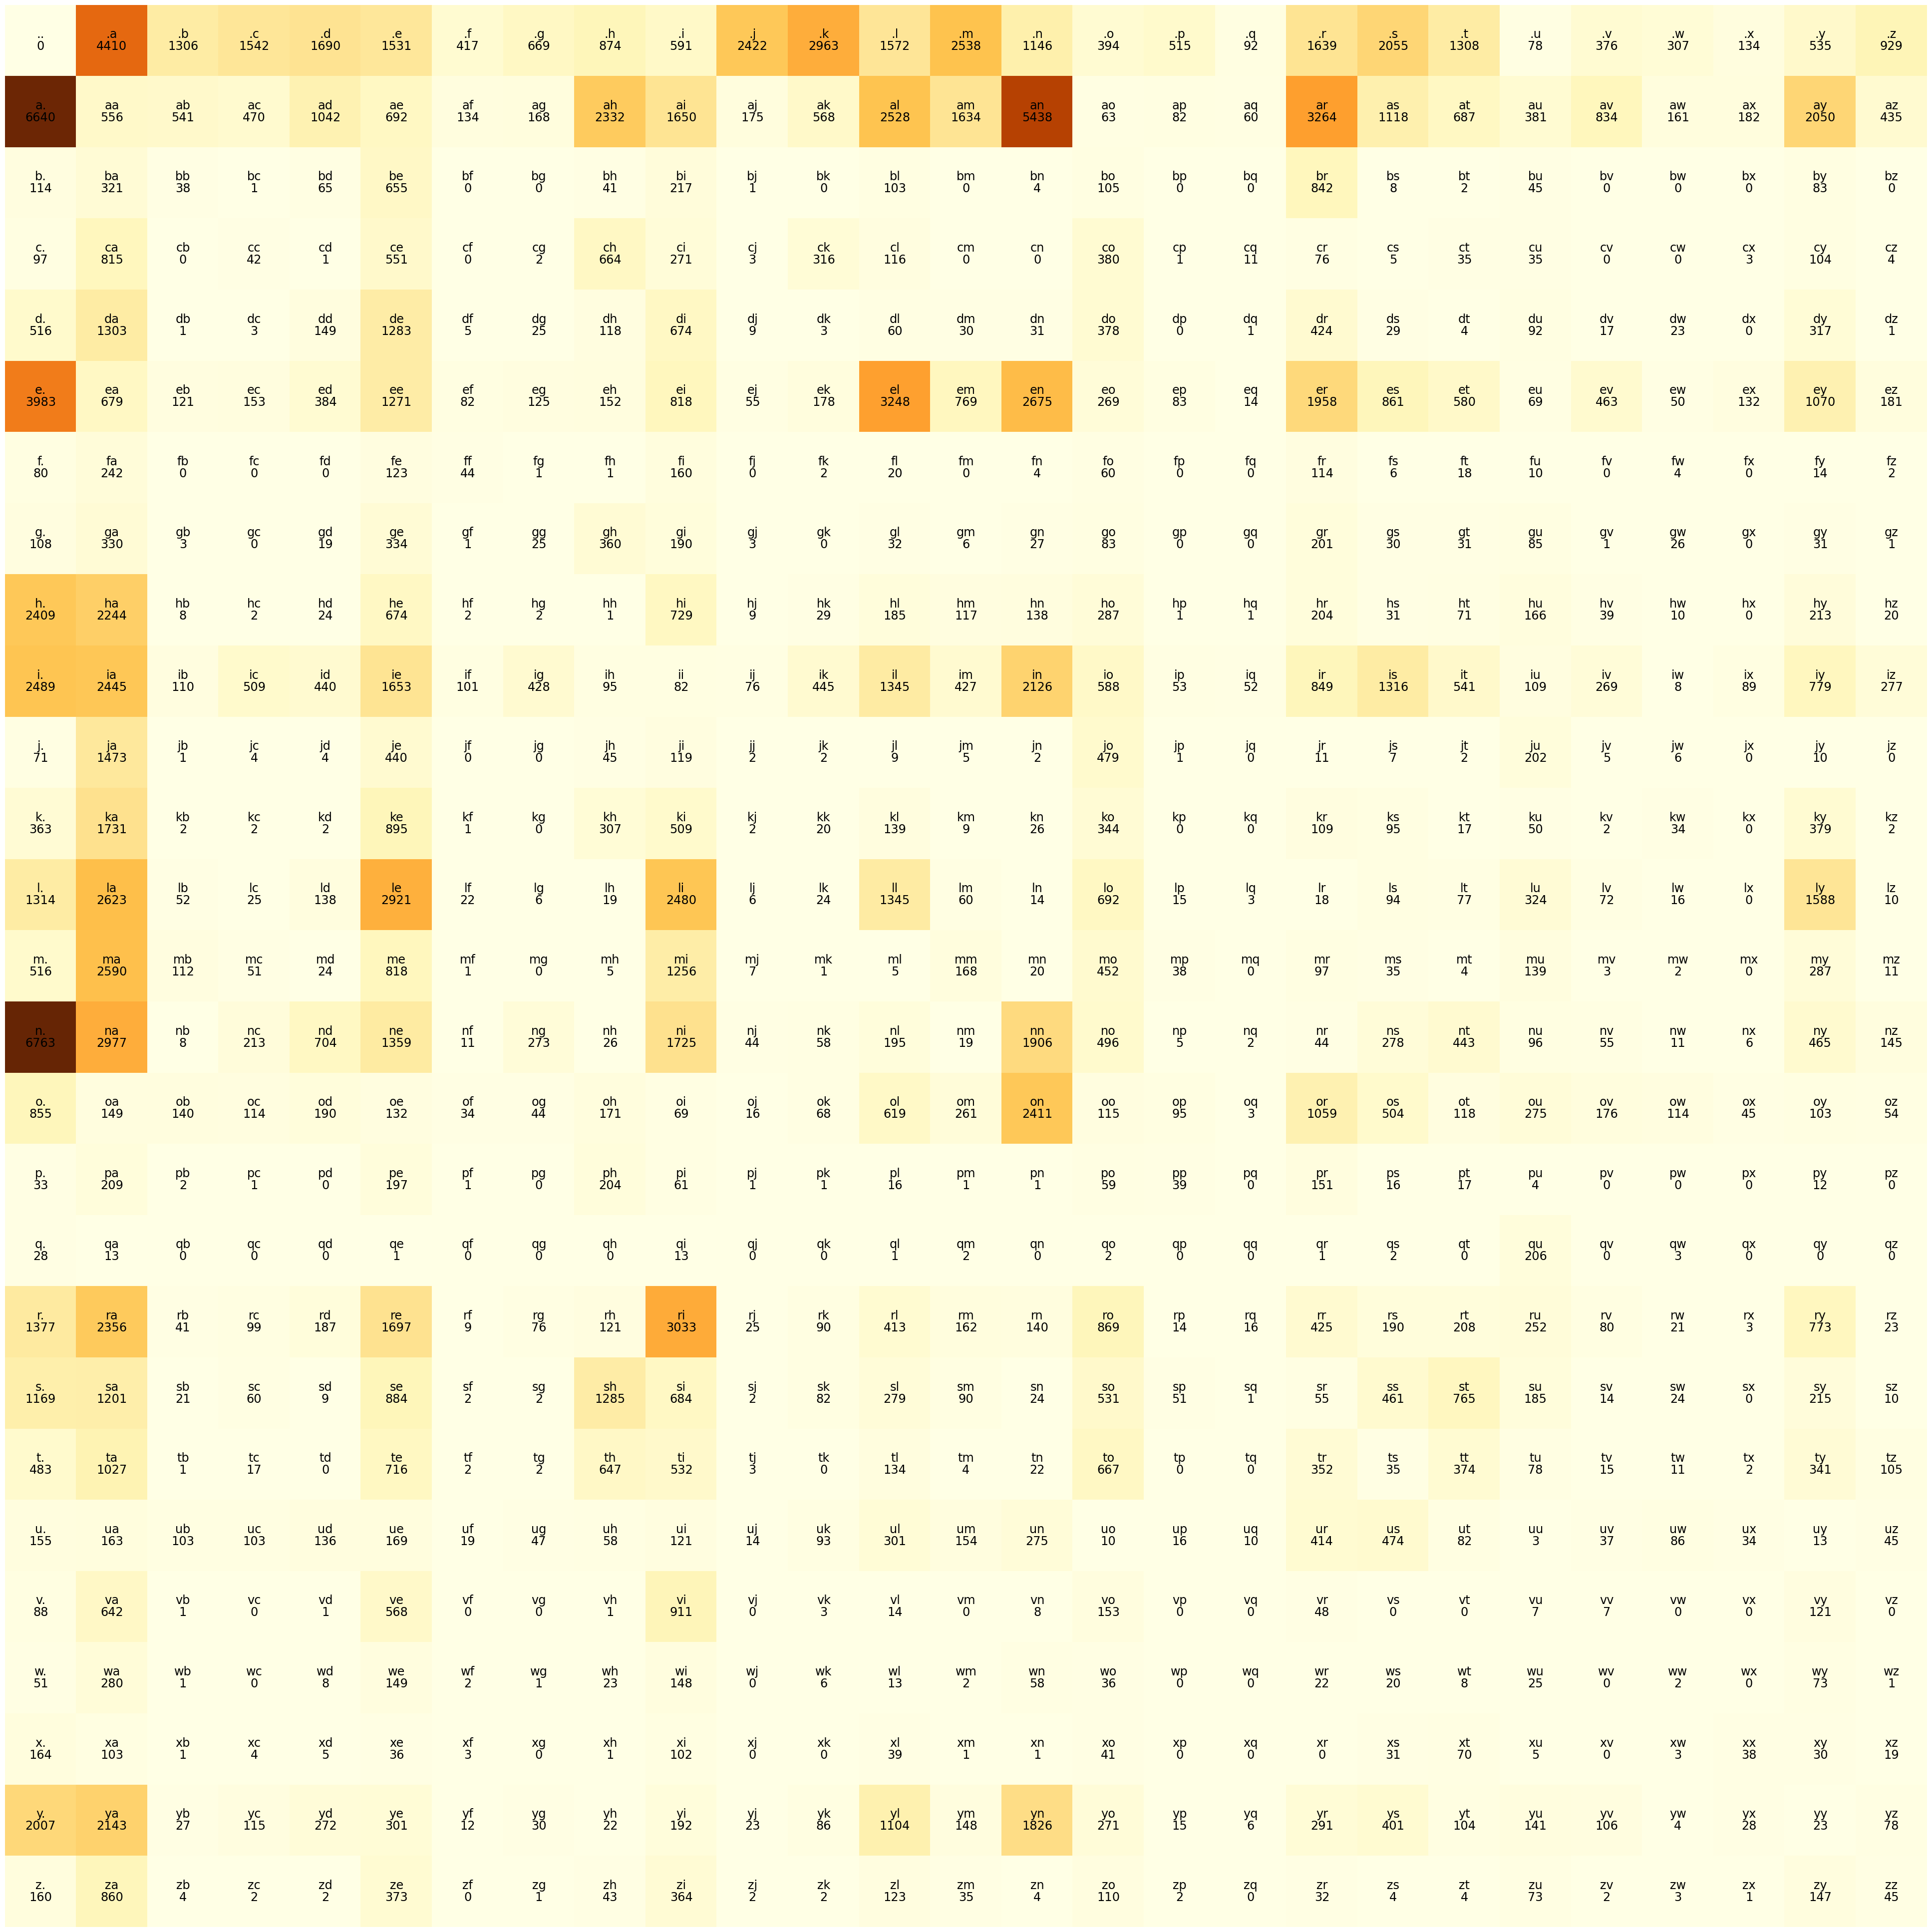

In [247]:
def viz_bigram_matrix(N: torch.Tensor, id_char: dict):
    plt.figure(figsize=(50,50))
    plt.imshow(N, cmap='YlOrBr') # matshow's size doesn't change so better to use imshow
    for i in range(27):
        for j in range(27):
            plt.text(i, j, id_char[j]+id_char[i], ha='center', va='bottom', fontsize='xx-large')   # ha: horizontal alignment
            plt.text(i, j, N[j, i].item(), ha='center', va='top', fontsize='xx-large')             # va: vertical alignment
    plt.axis('off')
    
viz_bigram_matrix(N, id_char)

## Train

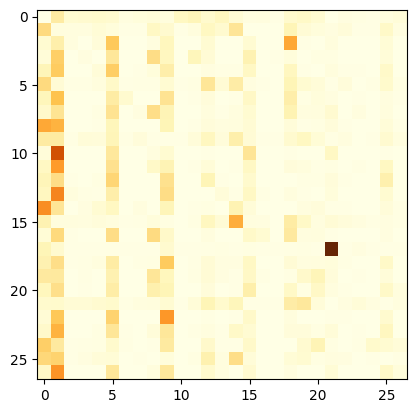

In [248]:
def make_porbability_matrix(logit_matrix):
    P = logit_matrix.float() # multinomial function only supports floating-point dtypes for input
    P /= P.sum(dim=1, keepdims=True) # broadcasting
    '''
    When you use P.sum(dim=1, keepdims=True) or P.sum(dim=1, keepdim=True), 
    both commands do exactly the same thing because keepdims is simply
    redirected to keepdim internally.
    '''
    return P

probability_matirx = make_porbability_matrix(N+1)
plt.imshow(probability_matirx, cmap='YlOrBr')

## Inference

In [249]:
# in this version of making characters, we only consider the previous character and not the wholr created characters so far
def make_names_multinomial(probability_matirx, num_words):
    names = []
    idx = 0
    for i in range(num_words):
        name = ''
        while True:
            # multinomial only supports floating-point dtypes for input
            idx = torch.multinomial(probability_matirx[idx], num_samples=1, replacement=True).item() # it should be probability value
            if idx == 0:
                break
            name += name.join(id_char[idx])

        names.append(name)

    return names

# Probability matrix is our trained "model"
names = make_names_multinomial(probability_matirx, 10)
print(names)

['cirmallla', 'ashakea', 'shah', 'z', 'areori', 'dystain', 'schaynararasamen', 'jayn', 'everevencad', 'fyvoreria']


## Evaluation

The likehood of all the training sequences to happen is the multiplication of their probabilities which we want them to be maximized since it is training data!
But since the multiplication makes the numebrs so small, we use their logs and we want to minimize its negative log likelihood.

In [250]:
def evaluate_model(model, words):
    log_likelihood = 0
    for k, v in words.items():
        p = model[char_id[k[0]], char_id[k[1]]]
        log_likelihood += torch.log(p).item()    # input should be tensor
    
    return -log_likelihood/len(words)

loss = evaluate_model(probability_matirx, bigrams)
print(f"Model's training loss is: {loss:.2f}")

Model's training loss is: 4.45
